In [2]:
import numpy as np
import os
import cv2

directory = 'CK+48'
dir_list = os.listdir(directory)
image_data_list = []
labels = []
emotions = []
l = 0

for data_dir in dir_list:
    # Check if the item is a directory
    if os.path.isdir(os.path.join(directory, data_dir)):
        data_list = os.listdir(os.path.join(directory, data_dir))
        for img in data_list:
            img_path = os.path.join(directory, data_dir, img)
            input_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
            
            # Check if the image was loaded correctly
            if input_img is None:
                print(f"Warning: Skipping invalid or unreadable image at {img_path}")
                continue  # Skip this image if it cannot be loaded
            
            input_img = cv2.resize(input_img, (48, 48))  # Resize to (48, 48)
            input_img = np.expand_dims(input_img, axis=-1)  # Add channel dimension to get (48, 48, 1)
            image_data_list.append(input_img)
            labels.append(l)
        print('Loaded images from ' + data_dir)
        emotions.append(data_dir)
        l += 1

# Convert list to numpy array and normalize
img_data = np.array(image_data_list, dtype='float32') / 255.0
print("Shape of img_data:", img_data.shape)


Loaded images from happy
Loaded images from contempt
Loaded images from fear
Loaded images from surprise
Loaded images from sadness
Loaded images from anger
Loaded images from disgust
Shape of img_data: (981, 48, 48, 1)


In [3]:
print(emotions)
def getLabel(id):
    return emotions[id]


['happy', 'contempt', 'fear', 'surprise', 'sadness', 'anger', 'disgust']


In [4]:
processed_images = []
for img in image_data_list:
    # Assuming the images are single-channel already
    equalized_img = cv2.equalizeHist(img)
    processed_images.append(equalized_img)

# Reshape and normalize for model input
processed_images = np.array(processed_images).reshape(-1, 48, 48, 1) / 255.0


In [5]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
num_classes=7
Y = keras.utils.to_categorical(labels, num_classes)
X_train, X_test, y_train, y_test = train_test_split(processed_images, Y, test_size=0.2,shuffle=True)
X_train.shape

(784, 48, 48, 1)

[0. 0. 1. 0. 0. 0. 0.]


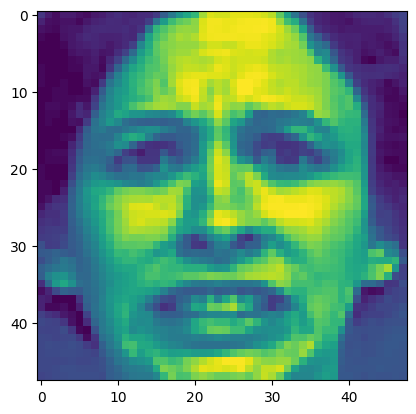

In [6]:
from matplotlib import pyplot as plt
print(y_train[499])
plt.imshow(X_train[499])
plt.show()

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy

from keras.metrics import categorical_accuracy

model=Sequential()
model.add(Conv2D(64,(3,3),input_shape=(48,48,1),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(num_classes,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Epoch 1/250
25/25 [==============================] - 10s 388ms/step - loss: 1.9063 - accuracy: 0.2105 - val_loss: 1.8700 - val_accuracy: 0.2234
Epoch 2/250
25/25 [==============================] - 9s 378ms/step - loss: 1.8690 - accuracy: 0.2423 - val_loss: 1.8249 - val_accuracy: 0.2234
Epoch 3/250
25/25 [==============================] - 14s 558ms/step - loss: 1.8392 - accuracy: 0.2449 - val_loss: 1.7202 - val_accuracy: 0.3909
Epoch 4/250
25/25 [==============================] - 11s 465ms/step - loss: 1.6201 - accuracy: 0.3788 - val_loss: 1.4985 - val_accuracy: 0.4569
Epoch 5/250
25/25 [==============================] - 10s 418ms/step - loss: 1.4585 - accuracy: 0.4324 - val_loss: 1.4392 - val_accuracy: 0.4873
Epoch 6/250
25/25 [==============================] - 9s 380ms/step - loss: 1.4175 - accuracy: 0.4630 - val_loss: 1.3756 - val_accuracy: 0.5076
Epoch 7/250
25/25 [==============================] - 10s 398ms/step - loss: 1.3097 - accuracy: 0.5026 - val_loss: 1.1210 - val_accuracy: 0

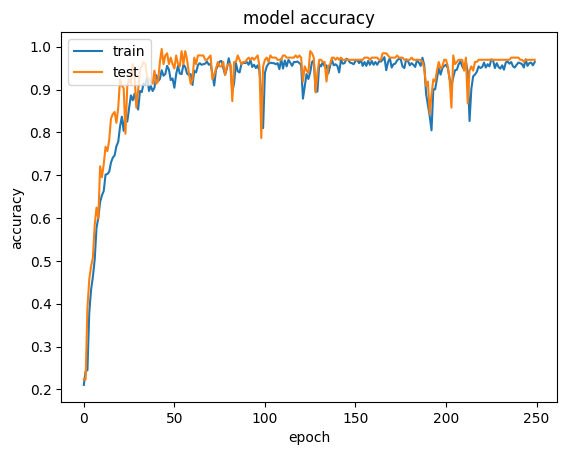

In [8]:
import matplotlib.pyplot as plt
history=model.fit(X_train, y_train,epochs=250,validation_data=(X_test, y_test))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [12]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

Final Training Accuracy: 0.9643
Final Validation Accuracy: 0.9695


In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

7/7 [==============================] - 1s 69ms/step - loss: 0.5093 - accuracy: 0.9695
Test Accuracy: 0.9695
